## Accessing Satellite Imagery with Google Earth Engine

Satellites provide a wealth of information about the world: monitoring human development, tracking climate change, and providing vital information at scale for disaster response. Over the past decades, the scale of publicly accessible satellite data has increased exponentially. This data is collected by many research consortia, often stored on servers and accessible with APIs unique to the mission. [Google's Earth Engine](https://earthengine.google.com/) hosts a large, multi-petabyte [catalog](https://developers.google.com/earth-engine/datasets/) of satellite imagery which can be accessed and queried with a common API, for free with a Google account. This service, which requires the technical knowledge and bankroll of a tech giant, is boon for using satellite imagery at scale to learn more about the world we live in. This post documents basic interaction with the Earth Engine API in python, focusing on how to get Sentinel-2 MSI imagery.

In [ ]:
!pip install eemont rasterio geopy

In [1]:
# Import Libraries

import ee  # Google Earth Engine
import eemont  # Extension to Google Earth Engine

from PIL import Image
import requests
import rasterio
import numpy as np
import datetime
import geopy
import geopy.distance
import matplotlib.pyplot as plt

### Autheticate Google Earth Engine Account

The first step of using Google Earth Engine is to authenticate your session, which can be done interactively in a jupyter notebook by running the following commands.

In [ ]:
ee.Authenticate()
ee.Initialize()

### Get ee.Geometry from the eeMont library

To query satellite imagery of a particular location on earth, we first need to create a Earth Engine [Geometry Object](https://developers.google.com/earth-engine/guides/geometries). I've found the eeMont python package that extends Google Earth Engine to be helpful in exploratory analysis, since it can return a Geometry Point based on a text query. Below is a query for Washington D.C.  

In [5]:
point = ee.Geometry.PointFromQuery("Washington DC", user_agent="earth_engine_example")

Which returns a single longitude, latitude pair for Washington D.C., as you would get if the same query was entered into Google Maps.

In [6]:
print(point)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Point",
    "arguments": {
      "coordinates": {
        "constantValue": [
          -77.0365427,
          38.8950368
        ]
      }
    }
  }
})


### Create Bounding Box Helper Function

For this example, I want to get a subset of Sentinel-2 Image. In requesting an image, it is necessary to request either the scale (i.e. sampling distance of pixel) of the image or the pixel dimensions of the subset. Sentinel-2 MSI Imagery has a [10m resolution](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR), however if I request a full image at that resolution it is too large. And if I request a image with a specified pixel dimension, then the image is downsampled to a worse resolution than the native 10m. 

To get an image subset with roughly native resolution, I created a function that makes a [bounding box](https://wiki.openstreetmap.org/wiki/Bounding_Box#:~:text=A%20bounding%20box%20(usually%20shortened,number%20between%20%2D180.0%20and%20180.0.) of a specified size  centered on an initial latitude and longitude point.

In [13]:
def BBoxFromPoint(bbox_size, lat_point, lon_point):
    """
    bbox_size - either square in km (one value) or two values in NS km, then EW km
    lat_point - lat center of bounding box
    lon_point - lon center of bounding box

    returns ee.Geometry object of bounding box
    """
    if type(bbox_size) == int or type(bbox_size) == float:
        bbox_size = np.array([bbox_size])

    if len(bbox_size) == 1:
        lat_km = bbox_size[0]
        lon_km = bbox_size[0]
    elif len(bbox_size) == 2:
        lat_km, lon_km = bbox_size
    else:
        raise ValueError("bbox_size must be either length 1 or 2")

    origin = geopy.Point(lat_point, lon_point)
    lat_min = (
        geopy.distance.geodesic(kilometers=lat_km / 2).destination(origin, bearing=180)
    )[0]
    lat_max = (
        geopy.distance.geodesic(kilometers=lat_km / 2).destination(origin, bearing=0)
    )[0]
    lon_min = (
        geopy.distance.geodesic(kilometers=lat_km / 2).destination(origin, bearing=270)
    )[1]
    lon_max = (
        geopy.distance.geodesic(kilometers=lat_km / 2).destination(origin, bearing=90)
    )[1]

    return ee.Geometry.BBox(lon_min, lat_min, lon_max, lat_max)

With this information, I created a bounding box of 5.12 km x 5.12 km so that when I ask for a 512 x 512 pixel image it is approximately at 10m resolution

In [14]:
DC_lon, DC_lat = point.coordinates().getInfo()
DC_bbox = BBoxFromPoint(5.12, DC_lat, DC_lon)

In [15]:
DC_bbox.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-77.06605134109452, 38.87197649154135],
   [-77.00703405890545, 38.87197649154135],
   [-77.00703405890545, 38.91809701712762],
   [-77.06605134109452, 38.91809701712762],
   [-77.06605134109452, 38.87197649154135]]]}

### Get Image Collection From Google Earth Engine

The first step of getting imagery from Google Earth Engine is to specify the dataset. Below this is done by running  `ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")`. This does not return the entire dataset (which is a good thing because it is extremely large), but creates a object on the user side that, when prompted by other methods, can make a request of Google's server. This is detailed in the [Client vs. Server](https://developers.google.com/earth-engine/guides/client_server) section of Google's documentation. 

After creating the ImageCollection object, the data we are interested can be specified with filter functions, in this case `filterBounds` for images intersecting the Geometry object, `filterDate` for specifying the date range to look for images, and `filter` for a generic filter which can query against properties of each image, listed [here](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) for Sentinel-2. The last `filter` selects images with 10% or less cloudy pixels.

In [59]:
DC_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(DC_bbox)
    .filterDate("2020-01-01", "2021-01-01")
    .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 5))
)

In the above image collection, multiple images will satisfy the geospatial, temporal, and cloud percentage requirements. Therefore, it is necessary to select a single image from the set of qualifying images. A simple way to do that is with the `first` method, which can be passed into the `ee.Image` constructor to make an image object.

In [60]:
DC_image = ee.Image(DC_collection.first())

To grab the metadata associated with this image, we need to call the `getInfo` method on the Image object. This is because the Image object exists on the Client side and has not yet made a request to Google's servers.

In [61]:
DC_Image_info = DC_image.getInfo()

The metadata of the image is returned as a python dictionary and contains a variety of metadata associated with the image, including the acquisition date. 

In [62]:
print("Image Info is a ", type(DC_Image_info))

Image Info is a  <class 'dict'>


In [63]:
print("Fields of Image Info:")
for key in DC_Image_info:
    print(key)

Fields of Image Info:
type
bands
version
id
properties


In [64]:
print("Start time of Image:\t", DC_Image_info["properties"]["system:time_start"])

print(
    "Date:\t\t\t",
    datetime.datetime.fromtimestamp(
        DC_Image_info["properties"]["system:time_start"] / 1000
    ).strftime("%c"),
)

print("Sentinel ID:\t\t", DC_Image_info["properties"]["DATATAKE_IDENTIFIER"])

Start time of Image:	 1579190537887
Date:			 Thu Jan 16 11:02:17 2020
Sentinel ID:		 GS2B_20200116T155609_014952_N02.13


To get the actual image from Google's servers, you need to call either `getThumbURL` or `getDownloadURL`. `getThumbURL` will generate a url with the image in the requested format. This function __requires__ a dictionary specifying the parameters necessary to generate the image. For instance, Sentinel-2 data has over 10 bands and which band should be mapped to Red, Green, and Blue is ambiguous. Below the bands B4, B3, B2 are mapped red, green, and blue respectively. For multispectral imagery (MSI) these bands correspond to their mapped colors, but for other formats of imagery such as those beyond the visible must be assigned to artificial colors.

In addition to specifying the bands, the pixel dimensions of the image, and the bounding box of the image, the data range of the image needs to be specified. According to the data description on the Google Earth Engine website, the data value of the band is the surface reflectance multiplied by 10,000. I've found decent results by setting the data range from $[0,4000]$, or a surface reflectance from 0% to 40%.

The url can be read into a PIL image by using the `requests` module and passing the raw response into `PIL.Image.open()`.

In [65]:
DC_url = DC_image.getThumbURL(
    {
        "format": "png",
        "bands": ["B4", "B3", "B2"],
        "dimensions": [512, 512],
        "region": DC_bbox,
        "min": 0,
        "max": 4000,
    }
)

In [66]:
DC_thumbURL_response = requests.get(DC_url, stream=True)

In [67]:
DC_PIL = Image.open(DC_thumbURL_response.raw)

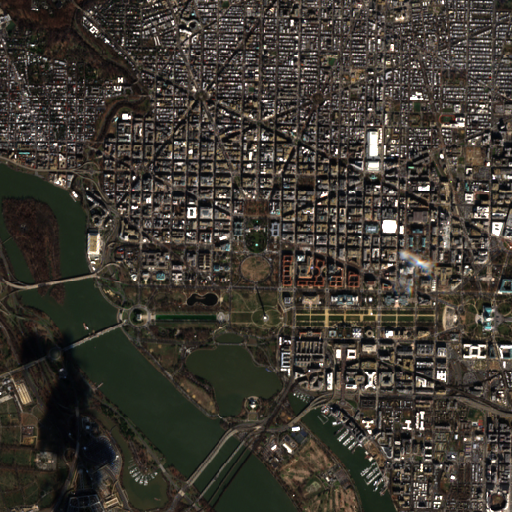

In [68]:
DC_PIL

Since the data is in a PIL Image, it can be saved easily with the `.save` method.

In [19]:
DC_PIL.save("Sentinel-2_DC.png")

### Download Image as a GeoTiff

The thumbnails from `getThumbURL` are meant to be visualized and therefore require either one band (grayscale) or three bands (RGB). However, to get the full data and all the bands collected you need to download the GeoTiff with `getDownloadURL`. The format is very similar to the `getThumbURL` method as it requires a dictionary specifying parameters of image. Instead of generating a png, the download url is a zip file which unzips into a GeoTiff. 

The code below generates the download url, downloads the image, uzips it, loads it with rasterio, and plots the image (same as above) and the histogram of the reflectance values

In [70]:
DC_downloadURL = DC_image.getDownloadURL(
    {
        "bands": ["B2", "B3", "B4", "B8"],
        "dimensions": [512, 512],
        "region": DC_bbox,
        "filePerBand": False,
    }
)

In [71]:
DC_download_response = requests.get(DC_downloadURL)

In [72]:
with open("DC_geotiff.zip", "wb") as fd:
    fd.write(DC_download_response.content)

In [73]:
import zipfile

with zipfile.ZipFile("DC_geotiff.zip", "r") as zip_ref:
    zip_ref.extractall()

In [74]:
import glob

fname = glob.glob("*.tif")

In [79]:
DC_dataset = rasterio.open(fname[0])

In [80]:
print("Image heigt, width:", DC_dataset.height, ",", DC_dataset.width)
print("Number Bands:", DC_dataset.count)
print("Datatype:", DC_dataset.dtypes[0])

Image heigt, width: 512 , 512
Number Bands: 4
Datatype: uint16


In [81]:
DC_raster = DC_dataset.read([3, 2, 1])

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


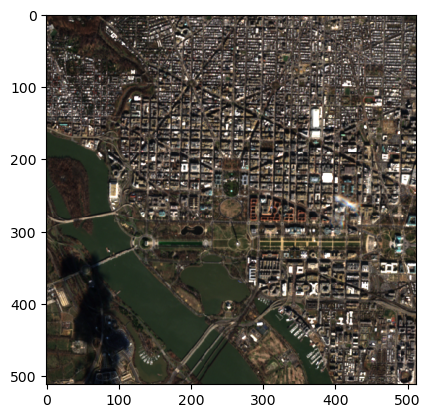

In [82]:
plt.imshow(np.moveaxis(DC_raster, 0, -1) / np.percentile(DC_raster, 99))

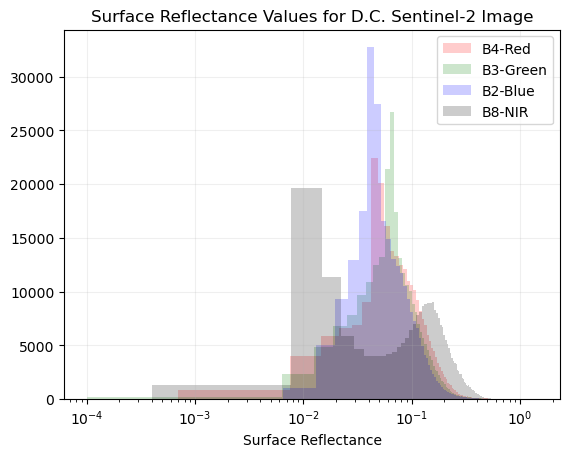

In [84]:
# Red band
plt.hist(
    (DC_dataset.read(3).flatten()) / 10000, 200, color="red", alpha=0.2, label="B4-Red"
)

# Blue band
plt.hist(
    (DC_dataset.read(2).flatten()) / 10000,
    200,
    color="green",
    alpha=0.2,
    label="B3-Green",
)

# Green band
plt.hist(
    (DC_dataset.read(1).flatten()) / 10000,
    200,
    color="blue",
    alpha=0.2,
    label="B2-Blue",
)

# NIR band
plt.hist(
    (DC_dataset.read(4).flatten()) / 10000,
    200,
    color="black",
    alpha=0.2,
    label="B8-NIR",
)

plt.xscale("log")
plt.xlabel("Surface Reflectance")
plt.grid(alpha=0.2)
plt.title("Surface Reflectance Values for D.C. Sentinel-2 Image")
plt.legend()
plt.show()

### Generate timelapse video

As an example of the power and flexibility of Google Earth Engine, here is a quick script to save frames for a timelapse video of the construction of [Fiery Cross Reef](https://en.wikipedia.org/wiki/Fiery_Cross_Reef), a coral reef in the South China Sea which was [terraformed by China into a naval base](https://www.cnbc.com/2017/06/30/china-builds-military-facilities-south-china-sea-islands.html) from 2013 to 2017.

In [145]:
fcr_bbox = BBoxFromPoint(0.03 * 256, 9.549167, 112.889167)

In [146]:
fcr_collection = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(fcr_bbox)
    .filterDate("2013-04-01", "2018-06-01")
    .filter(ee.Filter.lte("CLOUD_COVER", 50))
)

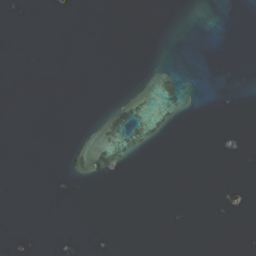

In [147]:
# test the example image

fcr_first_image = ee.Image(fcr_collection.first())

fcr_url = fcr_first_image.getThumbURL(
    {
        "format": "png",
        "bands": ["SR_B4", "SR_B3", "SR_B2"],
        "dimensions": [256, 256],
        "region": fcr_bbox,
        "min": 0,
        "max": 29000,
    }
)

fcr_first_response = requests.get(fcr_url, stream=True)

fcr_PIL = Image.open(fcr_first_response.raw)

fcr_PIL

In [152]:
# Loop through the images and save them

number_of_images = fcr_collection.size().getInfo()
fcr_list = fcr_collection.toList(fcr_collection.size())

for i in range(number_of_images):
    fcr_image = ee.Image(fcr_list.get(i))

    fcr_url = fcr_image.getThumbURL(
        {
            "format": "png",
            "bands": ["SR_B4", "SR_B3", "SR_B2"],
            "dimensions": [256, 256],
            "region": fcr_bbox,
            "min": 0,
            "max": 30000,
        }
    )

    fcr_response = requests.get(fcr_url, stream=True)
    fcr_PIL = Image.open(fcr_response.raw)

    fcr_PIL.save(f"fcr_images/fcr_{i:03}.png")